# YOLO-V3 

In this jupyter notebook I have implemented the Yolo-v3 algorithm. The link to the paper can be found [here](https://arxiv.org/pdf/1804.02767v1.pdf)

This Notebook will have the following sections:
* Importing Dependencies
* Intersection Over Union
* Non Max Supression
* Mean Average Precision
* Building YOLOv3 model architecture
* Loss function

Resources:
    The inspiration for this Jupyter Notebook is the youtube video linked [here](https://www.youtube.com/watch?v=Grir6TZbc1M&ab_channel=AladdinPersson)<br />
    The author implemented YOLOv3 in Pytorch. I borrowed the ideas he has implemented and wrote the same using **Tensorflow, Numpy and Keras**

### 0. Importing Dependencies

Follow these steps to get started with this notebook:<br /><br />
**1.** To **create a virtual environment** use the command:<br />
python -m venv YoloEnv<br /><br />
**2.** To **activate the environment** use the command:<br />
.\YoloEnv\Scripts\activate<br /><br />
**3.** To **install the required modules** use the command:<br />
pip install -r requirements.txt<br /><br />
**4.** To **use the virtual environment in this jupyter notebook** use the command:<br />
python -m ipykernel install --user --name=YoloEnv<br /><br />
You should be ready to follow along with the notebook after completing the above steps. Good luck!

In [1]:
import tensorflow as tf
import numpy as np
import config
from tqdm import tqdm
import glob
import cv2
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, LeakyReLU, Reshape
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [27]:
tf.__version__

'2.4.0'

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
EPOCHS = 3

### 1. IOU - Intersection Over Union

**Intersection over Union (IOU)** = (Area of Intersection of the 2 rectangle)/(Area of Union of 2 rectangels)

Assume you are given 2 bounding boxes B1 and B2. These bounding boxes are 2 lists, containing 4 values each [x1, x2, y1, y2]. (x1,y1) is the **upper left coordinate** of the bounding box. (x2, y2) is the **lower right coordinate** of the bounding box.
<br /><br />
* To find the **coordinates of the box of intersection**<br /><br />
x1 = max(b1[0], b2[0])<br />
y1 = max(b1[1], b2[1])<br />
x2 = min(b1[2], b2[2])<br />
y2 = min(b1[3], b2[3])<br /><br />

**Area of a box if the coordinates are known** = |(x1-x2) * (y1-y2)| <br /><br />
**Area of union if intersection is known** = (Area of Box 1 + Area of Box 2 - Area of Intersection)

In [4]:
def iou(b1, b2):
    '''
    b1 and b2 are arrays of dimensions (N, 4) 
        N - Batch Size
        4 - x1, y1, x2, y2
    '''
    
    x1 = tf.math.reduce_max([b1[..., 0:1], b2[..., 0:1]], axis=0)
    y1 = tf.math.reduce_max([b1[..., 1:2], b2[..., 1:2]], axis=0)
    x2 = tf.math.reduce_min([b1[..., 2:3], b2[..., 2:3]], axis=0)
    y2 = tf.math.reduce_min([b1[..., 3:4], b2[..., 3:4]], axis=0)
    
    intersection =  np.clip((x2 - x1), 0, 99999) * np.clip((y2 - y1), 0, 99999)
    area_b1 = abs((b1[..., 2: 3] - b1[..., 0: 1]) * (b1[..., 3: 4] - b1[..., 1: 2]))
    area_b2 = abs((b2[..., 2: 3] - b2[..., 0: 1]) * (b2[..., 3: 4] - b2[..., 1: 2]))
    
    union = area_b1 + area_b2 - intersection + 1e-6
    
    return intersection/union

In [5]:
def iou_width_height(boxes1, boxes2):
    """
    Parameters:
        boxes1 (tensor): width and height of the first bounding boxes
        boxes2 (tensor): width and height of the second bounding boxes
    Returns:
        tensor: Intersection over union of the corresponding boxes
    """
    boxes1, boxes2 = np.array(boxes1), np.array(boxes2)
    intersection = tf.math.reduce_min(boxes1[..., 0:1], boxes2[..., 0:1]) * tf.math.reduce_min(
        boxes1[..., 1:2], boxes2[..., 1:2]
    )
    union = (
        boxes1[..., 0:1] * boxes1[..., 1:2] + boxes2[..., 0:1] * boxes2[..., 1:2] - intersection
    )
    return intersection / union

In [6]:
b_1 = np.array([[2, 4, 5, 8], [3, 5, 10, 11]])
b_2 = np.array([[3, 5, 6, 9], [4, 6, 11, 12]])
b_1.shape

(2, 4)

In [7]:
iou(b_2, b_1)

array([[0.33333331],
       [0.55555555]])

### 2. Non Max Suppression

Suppose we have multiple bounding boxes for the same object, how do we deal with that? We handle this using a technique called non max suppression. I will list out the steps below:<br /><br />

* Set **probablity threshold** for bounding boxes and Non Max Suppression<br /><br />
* **Remove** all bounding boxes with **probablities below bounding box probablity threshold**<br /><br />
* Group the bounding boxes classwise<br /><br />
* Take the highest probablity bounding box and **calculate its IOU with all** other bounding boxes in that class<br /><br />
* **Remove the lower probablity bounding box** if its IOU is greater than Non Max Supression probablity threshold with highset probablity bounding box in that class

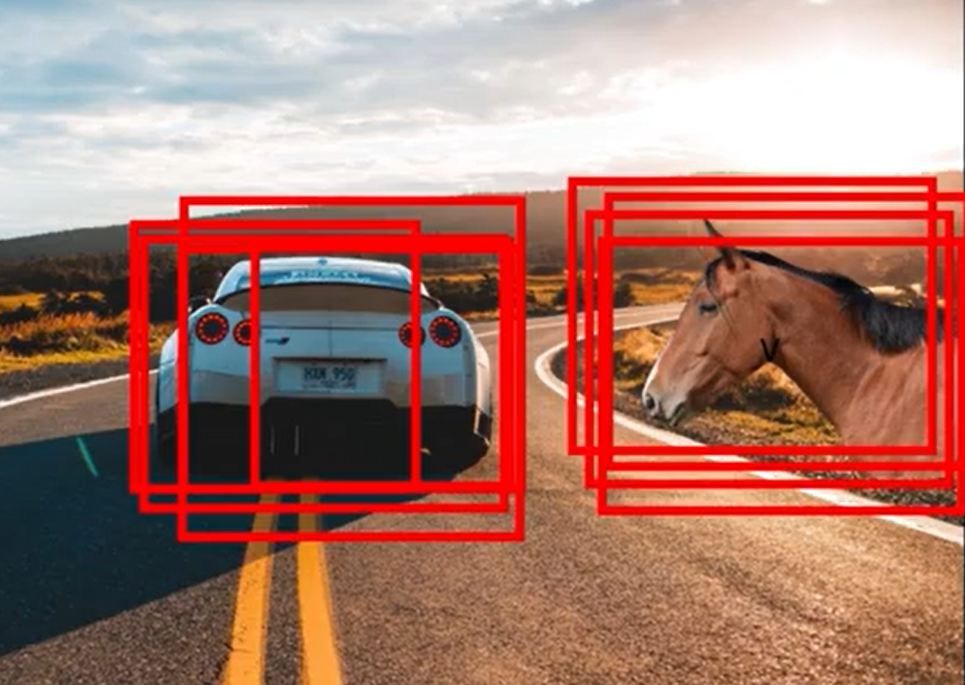

In [8]:
def nms(bboxes, iou_threshold, threshold):
    '''
        * bboxes: List of dimension (N, 6)
            [Class_number, probablity of bb, x1, x2, y1, y2]
            
        * iou_threshold: Boxes with overlap greater than this with 
            most probable box get removed if they have same class
            
        * threshold: Boxes with probablity less than this get removed
            before non max suppression is applied
        
        RETURNS:
            LIST chosen_box : list of bounding boxes after non max suppression
                            is applied to bboxes given initially
    '''
    assert type(bboxes) == list
    
    # remove bounding boxes if their probablity is below threshold
    bboxes = [box for box in bboxes if box[1] > threshold]
    
    #sort the bboxes by their probablity, with highest probablity at first
    bboxes = sorted(bboxes, key = lambda x: x[1], reverse = True)
    
    bboxes_final = []
    
    while bboxes:
        chosen_box = bboxes.pop(0)
        
        '''
        List comprehension to keep box if it is not in the same class
        as the highest probablity box or if it doesnt have high IOU
        with the highest probablity box.
        
        i.e keep boxes that are either not overlapping or of different class
        compared with the most probable bounding box.
        '''
        
        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or iou(box[2:], box[2:]) < iou_threshold
        ]
        
        bboxes_final.append(chosen_box)
        
    return chosen_box

### 3. Building the YOLO-v3 Model architecture

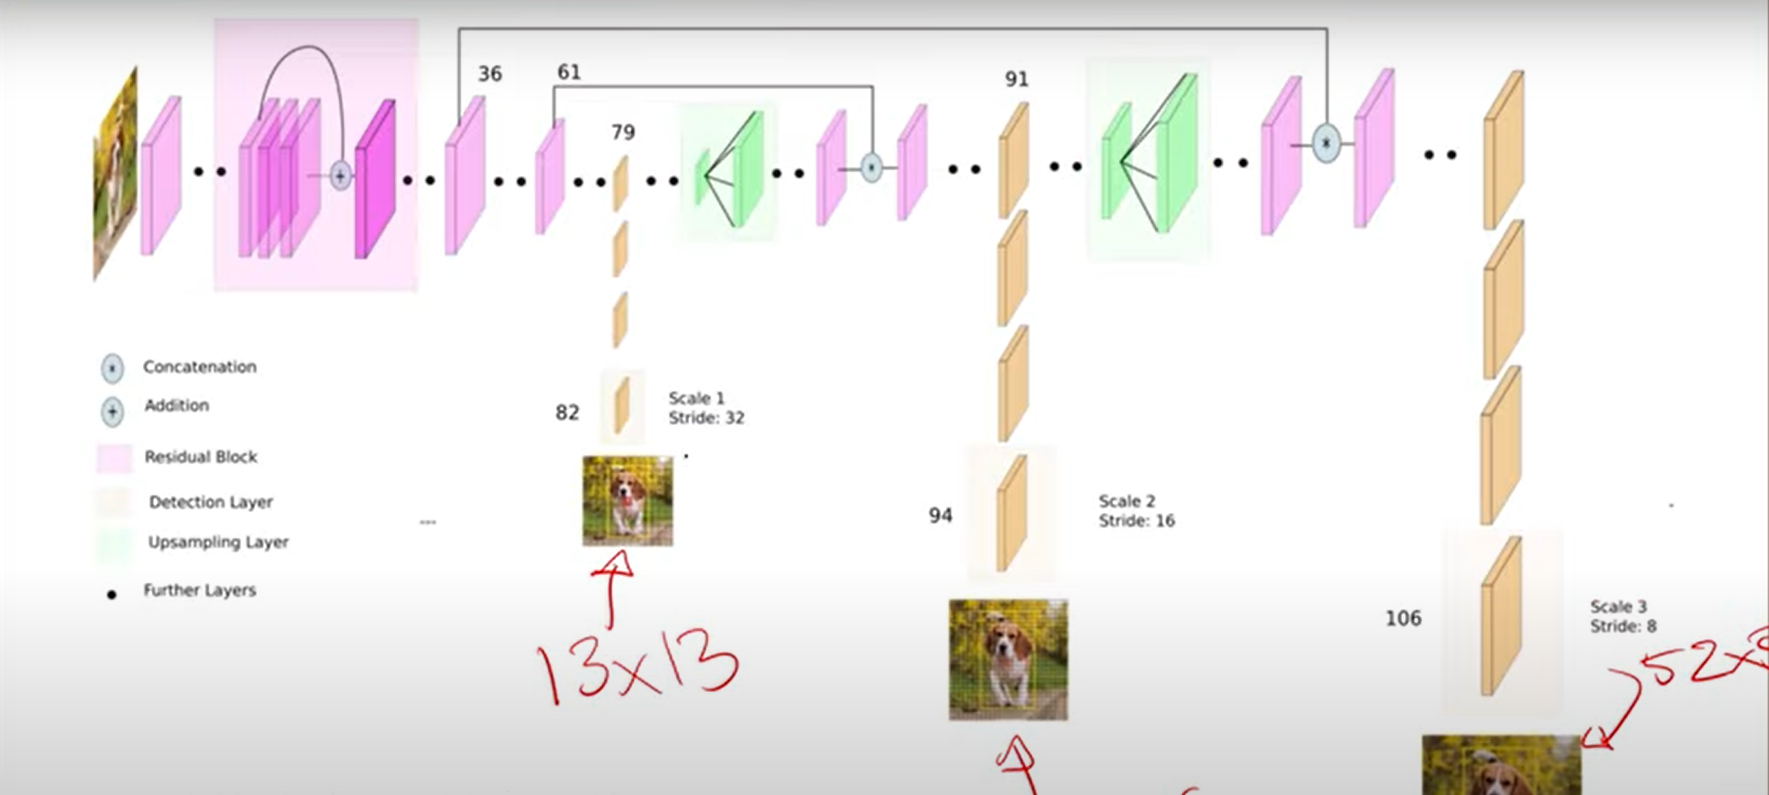

In [9]:
""" 
Information about architecture config:
Tuple is structured by (filters, kernel_size, stride) 
Every conv is a same convolution. 
List is structured by "B" indicating a residual block followed by the number of repeats
"S" is for scale prediction block and computing the yolo loss
"U" is for upsampling the feature map and concatenating with a previous layer
"""

configuration = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",
]

#### CNNBlock:

Whenever we use a convolutional layer, we generally pair it up with some activation function and Batch Normalization.
Instead of manually typing out all 3 each time, I've created a helper class to do that automatically.
<br /><br />
We use batch normalization and activation function everytime the CNNBlock is used **EXCEPT** the last layer (at the end of scale prediction)

In [10]:
class CNNBlock(Layer):
    def __init__(self, filters, kernel_size, bn_act=True, **kwargs):
        super().__init__()
        
        assert type(bn_act) == bool
        self.conv = Conv2D(filters, kernel_size, use_bias=not bn_act, **kwargs)
        self.bn = BatchNormalization()
        self.leaky = LeakyReLU(0.1)
        self.use_bn_act = bn_act

    def call(self, x):
        if self.use_bn_act:
            return self.leaky(self.bn(self.conv(x)))
        else:
            return self.conv(x)

#### Residual Block:
This is a concept introduced in the ResNet model. We add the input to a series of convolutional layers at the end of the series.
<br />
**input > conv_1 > conv_2 > (conv_3 + input)**
<br /><br />
In this residual block, if use_residual is set to true then input is added to the end, else it isn't.<br />
num_repeats specifies the number of repetations of conv(x, 1)-> conv(x//2, 3) we need [Here x is the number of channels]

In [11]:
class ResidualBlock(Layer):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super().__init__()
        self.layers = []
        for repeat in range(num_repeats):
            self.layers.append(
                Sequential(
                    [
                        CNNBlock(filters = channels // 2, kernel_size=1),
                        CNNBlock(filters = channels, kernel_size=3, padding='same'),
                    ]
                )
            )
            
            

        self.use_residual = use_residual
        self.num_repeats = num_repeats

    def call(self, x):
        for layer in self.layers:
            if self.use_residual:
                x = x + layer(x)
            else:
                x = layer(x)

        return x

#### Scale Prediction:
The YOLOv3 architecture has 3 different outputs, each at different scales.<br />
For instance if the input shape is (224, 224, 3) the 3 outputs will be of shape:
* 3 28 28 6
* 3 14 14 6
* 3 7 7 6

<br />
Imagine a 28x28 grid layed over the 224, 224 image. Each grid is responsible to output [p_o, class, x, y, w, h]
 
 * p_o: Probablity that an object is there in that cell of the 28x28 grid
 * class: What object that is
 * x and y: Location of object within that cell
 * w: Width of bounding box as a ratio to cell width
 * h: Height of bounding box as a ratio to cell height

<br />
The above was for 28x28. This is done 2 more times to lay a 7x7 grid and 14x14 grid over the 224, 224 image.<br />
The reason to have 3 outputs is that the 7x7 grid can specialize in locating large and near objects while the 28x28 grid, which has smaller cells, can locate smaller and far away objects.
<br /><br />
NOTE: The 3 in the shape (3, 28, 28, 6) is to say that we have 3 predefined anchor boxes. 

In [12]:
class ScalePrediction(Layer):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.pred = Sequential(
            [CNNBlock(filters = 2 * in_channels, kernel_size=3, padding="same"),
            CNNBlock(
                filters = (num_classes + 5) * 3, bn_act=False, kernel_size=1
            ),]
        )
        self.num_classes = num_classes

    def call(self, x):
        output = self.pred(x)
        
        output = tf.transpose(
            Reshape((3, self.num_classes + 5, x.shape[1], x.shape[2]), input_shape = output.shape)(output),
            perm = [0, 1, 3, 4, 2]
        )
        
        return output

#### YOLOv3
In this class, we inherit from the tf.keras.models.Model class to create the YOLOv3 model as specified in the config list

In [13]:
class YOLOv3(Model):
    def __init__(self, in_channels = 3, num_classes = 1):
        super(YOLOv3, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self._layers = self._create_conv_layers()
        
    def call(self, x):
        outputs = []  # for each scale
        route_connections = []
            
        for layer in self._layers:
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue

            x = layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, tf.keras.layers.UpSampling2D):
                x = tf.keras.layers.Concatenate(axis = -1)([x, route_connections[-1]])
                route_connections.pop()
        
        return outputs
    
    def _create_conv_layers(self):
        layers = []
        in_channels = self.in_channels
        
        for module in configuration:
            if isinstance(module, tuple):
                out_channels, kernel_size, strides = module
                layers.append(
                    CNNBlock(
                        filters = out_channels,
                        kernel_size = kernel_size,
                        strides = strides,
                        padding = "same" if module[1] == 3 else "valid"
                    )
                )
                in_channels = out_channels
                
            elif isinstance(module, list):
                layers.append(ResidualBlock(in_channels, num_repeats = module[1]))
                
            elif isinstance(module, str):
                if module == "S":
                    
                    layers += [
                        ResidualBlock(in_channels, use_residual=False, num_repeats=1),
                        CNNBlock(in_channels // 2, kernel_size=1),
                        ScalePrediction(in_channels // 2, num_classes=self.num_classes),
                    ]
                    
                    in_channels = in_channels // 2

                elif module == "U":
                    layers.append(tf.keras.layers.UpSampling2D(size = (2, 2)))
                    in_channels = in_channels * 3
            
        return layers
                

When the matrix comes to the upsampling layer, it is only half the required size
Got inputs shapes: [(4, 14, 14, 256), (4, 14, 14, 512)]

In [14]:
# Testing if the model works by running a forward pass

num_classes = 1
IMAGE_SIZE = 256
sample_cases = 5

model = YOLOv3(in_channels = 3, num_classes = 1)
test = tf.random.uniform(shape = (sample_cases, IMAGE_SIZE, IMAGE_SIZE, 3))
out = model(test)

print(f"Number of Scale Predictions: {len(out)}") #The 3 here corrosponds to the number of scale predictions

assert out[0].shape == (sample_cases, 3, IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes + 5)
assert out[1].shape == (sample_cases, 3, IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes + 5)
assert out[2].shape == (sample_cases, 3, IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes + 5)


print("Scale 0 shape: ", sample_cases, 3, IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes + 5)
print("Scale 1 shape: ", sample_cases, 3, IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes + 5)
print("Scale 2 shape: ", sample_cases, 3, IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes + 5)

print("Success!")

Number of Scale Predictions: 3
Scale 0 shape:  5 3 8 8 6
Scale 1 shape:  5 3 16 16 6
Scale 2 shape:  5 3 32 32 6
Success!


### Loss Function

In [15]:
x = np.array([[0, 22, 22, 22], [0, 1, 2, 3], [1, 2, 3, 4], [0, 2, 3, 4]])
x[..., 0:1][x[..., 0] == 0]

array([[0],
       [0],
       [0]])

In [16]:
class YoloLoss(Layer):
    def __init__(self):
        super().__init__()
        self.mse = tf.keras.losses.MeanSquaredError()
        self.bce = tf.keras.losses.BinaryCrossentropy(from_logits = True)
        self.entropy = tf.keras.losses.BinaryCrossentropy(from_logits = True)
        self.sigmoid = tf.math.sigmoid
        
        self.lambda_class = 1
        self.lambda_noobj = 10
        self.lambda_obj = 1
        self.lambda_box = 10
        
    def call(self, prediction, target, anchors):
        obj = target[..., 0] == 1
        noobj = target[..., 0] == 0
        
        no_object_loss = self.bce(
            prediction[..., 0:1][noobj], target[..., 0:1][noobj]
        )
        
        prediction = np.reshape(np.array(prediction), prediction.shape)
        target = np.reshape(np.array(target), target.shape)
        
        anchors = tf.reshape(anchors, (1, 3, 1, 1, 2))
        anchors = tf.cast(anchors, tf.float32)
        
        box_preds = tf.concat(
            [self.sigmoid(prediction[..., 1:3]), tf.math.exp(prediction[..., 3:5]) * anchors],
            axis = -1)
        
        ious = iou(
            box_preds[obj], target[..., 1:5][obj]
        )
        
        object_loss = self.mse(
            self.sigmoid(prediction[..., 0:1][obj]), ious * target[..., 0:1][obj]
        )

        
        prediction[..., 1:3] = self.sigmoid(prediction[..., 1:3])
        
        target[..., 3:5] = tf.math.log(
            (1e-16 + target[..., 3:5] / anchors)
        )
        
        box_loss = self.mse(prediction[..., 1:5][obj], target[..., 1:5][obj])


        class_loss = self.entropy(
            (prediction[..., 5:][obj]), (target[..., 5:][obj]),
        )
        
        
        return (
            tf.cast(box_loss * self.lambda_box, tf.float32) +
            tf.cast(self.lambda_obj * object_loss, tf.float32) +
            tf.cast(self.lambda_noobj * no_object_loss, tf.float32) +
            tf.cast(self.lambda_class * class_loss, tf.float32) 
        )

### DataLoader

### Calculation of Coordinates

#### Formulas to calculate box coordinates if image coordinate is given

* x_cell and y_cell = int(S * x_image) - S * x_image
* width and height_cell = S * width

Example: Let **S = 8, x = 0.5, y = 0.5, width = 0.25, height = 0.25**


#### Calculating x_cell and y_cell
S*x = 8 * 0.5 = 4.0                
int(S*x) = 4                       
x_cell = S*x - int(S*x) = 0.0      

#### Calculating Width and Height
width_cell = S*width               
           = 8 * 0.25 = 2                  
                        
Coordinates of bbox within given cell = **[0.0, 0.0, 2, 2]**


### Targets

From building the model above we know that: <br />
if the input image is of **dimension (h, h, channels)** and **anchor boxes per scale prediction is a**, then output will be:<br /><br />
output[0]: a, h/8, h/8,   num_classes + 5 <br />
output[1]: a, h/16, h/16, num_classes + 5 <br />
output[2]: a, h/32, h/32, num_classes + 5 <br />

Therefore the targets for the corrosponding image should also be a list of same dimension, filled with zeros except for the cells where objects are present

In [17]:
class KaggleLicence(Sequence):

    def __init__(
        self,
        data_directory,
        S = np.array([8, 16, 32]),
        anchors = config.ANCHORS[0] + config.ANCHORS[1] + config.ANCHORS[2],
        batch_size = 4,
        image_height = 256,
        ignore_iou_threshold = 0.45,
    ):
        
        self.x = glob.glob(f'{data_directory}/*.png')
        self.y = [image_name.replace('.png', '.xml') for image_name in self.x]
        self.annotations = ["<xmin>", "<ymin>", "<xmax>", "<ymax>"]
        self.S = S
        self.anchors = anchors
        self.batch_size = batch_size
        self.image_height = image_height
        self.ignore_iou_threshold = ignore_iou_threshold

    def __len__(self):
        return int(np.ceil(len(self.x) / self.batch_size))
    
    def resizeImage(self, image):
        '''
        INPUTS:
            image: output of cv2.imread(path)
        
        OUTPUTS:
            resized image of size (image_height, image_height, 3)
        '''
        return cv2.resize(image, (self.image_height, self.image_height))
    
    def readImage(self, path):
        '''
        INPUTS:
            path: the file path to the image that we need to read
            
        OUTPUTS:
            we read the image in the given path and normalize it by dividing it by 255.0
        '''
        return cv2.imread(path)/255.0
    
    def getPoints(self, path):
        '''
        INPUTS:
            path: the file path where the xml file is store. This file has bbox coordinates
        
        OUTPUTS:
            coordinates: [x_min, y_min, x_max, y_max]
            
        * We read the xml file, find the annotation values and store them in a list called coordinates
        '''
        
        with open(path, 'r') as f:
            data = f.read()
        coordinates = []

        for point in self.annotations:
            points = [x.split('</')[0] for x in data.split(point)[1:]]
            if coordinates == []:
                coordinates = [[int(x)] for x in points]

            else:
                for index, x in enumerate(points):
                    coordinates[index].append(int(x))

        return coordinates
        
    def getBatch(self, start_idx, stop_idx):
        '''
        INPUTS:
            start_idx: Start index of current batch. => iteration_number * batch_size
            stop_idx: Stop index of current batch. => (iteration_number + 1) * batch_size
            
        OUTPUTS:
            output_1 -> resized images of size (batch_size, image_height, image_height, 3)
            
        FUNCTION:
            * We read the images and coordinates and store them in x_idx and y_idx
            * Get image height and width before resizing
            * Scale the bounding box coordinates to a value between 0 and 1 such that it works after resizing the images
            * resize the images
        '''
        
        x_idx = np.array(list(map(self.readImage, self.x[start_idx: stop_idx])))
        y_idx = list(map(self.getPoints, self.y[start_idx: stop_idx]))

        for index, sample in enumerate(y_idx):
            # looping over the batch of coordinates
            
            for count, bbox in enumerate(sample):
                # looping over each bounding box in the image
                
                height, width = x_idx[index].shape[0:2]  # original image height and width before resizing
                
                scaled_bbox = [(y_idx[index][count][2] + y_idx[index][count][0]) / (2 * width),
                               (y_idx[index][count][3] + y_idx[index][count][1]) / (2 * height),
                               (y_idx[index][count][2] - y_idx[index][count][0]) / (width),
                               (y_idx[index][count][3] - y_idx[index][count][1]) / (height),
                               1
                              ]

                y_idx[index][count] = scaled_bbox

        return np.array(list(map(self.resizeImage, x_idx))), np.array(y_idx)
    
    def getLabel(self, targets, coordinate_batch):
        '''
        INPUTS
            * targets: Numpy arrays filled with 0's.
                            shape: [(batch, 3, S1, S1, 6), (batch, 3, S2, S2, 6), (batch, 3, S3, S3, 6)]

            * coordinate_batch: Bounding box coordinates of the current batch of images.
                            shape: (batch,)
                            shape of each instance: (num_bboxes_in_image, 5)  [NOTE: num_bboxes_in_image is usually 1 or 2]
                            last dimension: [x, y, width, height, class_label]
                            
        OUTPUTS:
            * targets: The target corrosponding to each image in the batch of images in coordinate_batch
                            shape: [(batch, 3, S1, S1, 6), (batch, 3, S2, S2, 6), (batch, 3, S3, S3, 6)] 
        '''
        
        for image_index, image in enumerate(coordinate_batch):
            #looping over each image in batch
            
            for bbox in image:
                #looping over each bounding box in the image
                
                bbox = np.array(bbox)
                anchor_scores = []  # IOU scores of each anchor with the bbox in the current iteration
                anchor_idx = []     # np.argsort() in descending of anchor_scores
                
                for anchor_instance in self.anchors:
                    #looping over each of the anchors [in this case 9 anchors, 3 per scale]
                    
                    iou_anchors = iou_width_height(bbox[..., 2:4], anchor_instance)  #iou score of anchor in loop with bbox
                    anchor_scores.append(iou_anchors)
                    
                anchor_idx = np.array(anchor_scores).argsort()[::-1]
                
                x, y, width, height, class_label = bbox     #unpacking bbox coordinates [x, y, width, height, class_label]
                has_anchor = [False] * 3     
                
                # There needs to be a target bounding box for each bounding box in all 3 scales
                # output[0], output[1] and output[2]; each of these need to have one anchor for all bboxes.
                # to do this we create has_anchor and store False. We change that to true when 
                # we give the bbox an anchor in that scale which coorsponds to the index in the list
                
                
                for anchor_index in anchor_idx:
                    scale_index = anchor_index // len(self.S)  #find which scale (S) this particular anchor belongs to
                                                                # takes value of 0 1 or 2
                
                    if not isinstance(scale_index, int):
                        scale_index = scale_index[0]
                        
                    anchor_on_scale = anchor_index % len(self.S)  #given scale (S) find which anchor within the scale 
                    S = self.S[scale_index]                       #Getting S value of the scale. By default: 8 16 or 32
                    
                    
                    i, j = int(S * y), int(S * x)           
                    #Example: let x and y coordinates be 0.5 and 0.5. Let the scale be 16. i and j will be 8 and 8
                    #         This means that the bbox belongs to the 8th row 8th column
                    
                    
                    anchor_status = targets[scale_index][image_index][anchor_on_scale, i, j, 0]
                                    # if this is 1 then the anchor in that scale in that grid for that image is taken
                                    # 0 by default. We will change it to one if we pick the anchor
                    
                    
                    if not anchor_status and not has_anchor[scale_index]:
                        targets[scale_index][image_index][anchor_on_scale, i, j, 0] = 1
                        x_cell, y_cell = S*x - j, S*y - i           
                        width_cell, height_cell = width * S, height * S
                        
                        box_coordinates = [x_cell, y_cell, width_cell, height_cell]
                        targets[scale_index][image_index][anchor_on_scale, i, j, 1:5] = box_coordinates
                        targets[scale_index][image_index][anchor_on_scale, i, j, 5] = class_label
                        
                       # targets[scale_index][image_index][anchor_on_scale, i, j] 
                       #                                                  = [1, x_cell, y_cell, width, height, class_label]
                        
                        
                    elif not anchor_status and anchor_scores[anchor_index] > self.ignore_iou_threshold:
                        targets[image_index][scale_index][anchor_on_scale, i, j, 5] = -1
                        
        return targets
    
    
    def __getitem__(self, idx):
        
        start_idx = idx * self.batch_size
        stop_idx = start_idx + self.batch_size
        
        x_batch, coordinate_batch = self.getBatch(start_idx, stop_idx)
        #refer function getBatch in this same class to get more info on what x_batch and coordinate_batch mean
        
        targets = [np.zeros(shape = (len(x_batch), len(self.anchors)//3, S, S, 6)) for S in self.S]
        # this works as input to the getLabels function. Refer that function in this same class for more info
        
        targets = self.getLabel(targets = targets, coordinate_batch = coordinate_batch)
        
        return x_batch, targets

### Utilities

In [18]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    cmap = plt.get_cmap("tab20b")
    class_labels = config.LICENCE_CLASSES
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle patch
    for box in boxes:

        assert len(box) == 6, "box should contain class pred, confidence, x, y, width, height"
        if list(box[4:]) != list([0, 0]):
            class_pred = box[0]
            box = box[2:]
            
            upper_left_x = box[0] - box[2] / 2
            upper_left_y = box[1] - box[3] / 2

            rect = patches.Rectangle(
                (upper_left_x * width, upper_left_y * height),
                box[2] * width,
                box[3] * height,
                linewidth=2,
                edgecolor="yellow",
                facecolor="none",
            )
            # Add the patch to the Axes
            ax.add_patch(rect)
#             plt.text(
#                 upper_left_x * width,
#                 upper_left_y * height,
#                 s="licence",
#                 color="white",
#                 verticalalignment="top",
#                 bbox={"color": "yellow", "pad": 0},
#             )

    plt.show()

In [19]:
def cells_to_bboxes(predictions, anchors, S, image_height = 256, is_preds=True):
    """
    Scales the predictions coming from the model to
    be relative to the entire image such that they for example later
    can be plotted
    
    INPUT:
        predictions: tensor of size (N, 3, S, S, num_classes+5)
        anchors: the anchors used for the predictions
        S: the number of cells the image is divided in on the width (and height)
        is_preds: whether the input is predictions or the true bounding boxes
        
    OUTPUT:
        converted_bboxes: the converted boxes of sizes (N, num_anchors, S, S, 1+5) with class index,
                          object score, bounding box coordinates
    """
    
    anchors = np.array(anchors)
    predictions = np.array(predictions)
    BATCH_SIZE = predictions.shape[0]
    num_anchors = len(anchors)
    box_predictions = predictions[..., 1:5]
    
    if is_preds:
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
        box_predictions[..., 0:2] = tf.math.sigmoid(box_predictions[..., 0:2])
        box_predictions[..., 2:] = tf.math.exp(box_predictions[..., 2:]) * anchors
        scores = tf.math.sigmoid(predictions[..., 0:1])
        
        best_class = np.argmax(np.array(predictions[..., 5:]), axis = -1)
        
    else:
        scores = predictions[..., 0:1]
        best_class = predictions[..., 5:6]
    
    cell_indices = (
        np.arange(S)
    .reshape(1, -1)
    .repeat(S, axis = 0)
    .reshape(1, S, S, -1)
    .repeat(3, axis = 0)
    .reshape(1, 3, S, S, 1)
    .repeat(predictions.shape[0], axis = 0)
    )
    

    
    x = 1 / S * (box_predictions[..., 0:1] + cell_indices)
    y = 1 / S * (box_predictions[..., 1:2] + tf.cast(tf.transpose(cell_indices, perm = [0, 1, 3, 2, 4]), tf.float64))
    
    w_h = 1 / S * box_predictions[..., 2:4]
    
    y = tf.cast(np.array(y), tf.float64)
    best_class = tf.cast(np.reshape(best_class, (-1, 3, S, S, 1)), tf.float64)
    scores = tf.cast(scores, tf.float64)
    
    converted_bboxes = tf.concat(
        (best_class, scores, x, y, w_h),
        axis=-1)
    
    converted_bboxes = np.array(converted_bboxes).reshape(BATCH_SIZE, num_anchors * S * S, 6)
    
    return np.array(converted_bboxes.tolist())

<ipython-input-17-f8673c171ef2>:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_idx = np.array(list(map(self.readImage, self.x[start_idx: stop_idx])))
<ipython-input-17-f8673c171ef2>:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(list(map(self.resizeImage, x_idx))), np.array(y_idx)


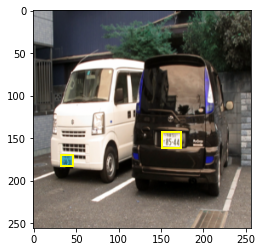

In [20]:
test = KaggleLicence(
    data_directory = 'DATASET/images/test',
    batch_size = 8
).__iter__()

for x, y in test:
    bboxes = cells_to_bboxes(y[0], anchors = config.ANCHORS[1], S = 8, is_preds = False)
    plot_image(x[2], bboxes[2])
    break

### Training

In [21]:
def apply_gradient(optimizer, model, loss_fn, anchors, x, y):
    losses = []
    with tf.GradientTape() as tape:
        logits = model(x)
        loss_value = loss_fn(prediction = logits[0], target = y[0], anchors = anchors[0]
                            ) + loss_fn(prediction = logits[1], target = y[1], anchors = anchors[1]
                                       ) + loss_fn(prediction = logits[2], target = y[2], anchors = anchors[2])
        
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    loss_value = np.mean(loss_value)
    return loss_value

In [22]:
def train_fn(train_loader, model, optimizer, loss_fn, scaled_anchors):
    loop = tqdm(train_loader, leave=True)
    losses = []
    for batch_idx, (x, y) in enumerate(loop):

        losses.append(apply_gradient(optimizer, model, YoloLoss(), scaled_anchors, x, y))

        # update progress bar
        mean_loss = sum(losses) / len(losses)
        loop.set_postfix(loss=mean_loss)

In [23]:
def main(EPOCHS):
    model = YOLOv3(num_classes=config.NUM_CLASSES)
    
    optimizer = tf.keras.optimizers.Adam(
        learning_rate = config.LEARNING_RATE
    )
    
    loss_fn = YoloLoss()
        
    train_dataloader = KaggleLicence(
                data_directory = 'DATASET/images/train',
                S = [8, 16, 32],
                anchors = config.ANCHORS[0] + config.ANCHORS[1] + config.ANCHORS[2],
                batch_size = 16,
                image_height = 256,
                ignore_iou_threshold = 0.45).__iter__()
    
    test_dataloader = KaggleLicence(
                data_directory = 'DATASET/images/test',
                S = [8, 16, 32],
                anchors = config.ANCHORS[0] + config.ANCHORS[1] + config.ANCHORS[2],
                batch_size = 16,
                image_height = 256,
                ignore_iou_threshold = 0.45).__iter__()
    
    
    scaled_anchors = (
        np.array(config.ANCHORS)
        * np.array([[x, x] for x in config.S])
    )
    
    for epoch in range(EPOCHS):
        train_fn(train_dataloader, model, optimizer, loss_fn, scaled_anchors)

    return model

In [24]:
%%time
YOLO_model = main(EPOCHS = EPOCHS)

0it [00:00, ?it/s]<ipython-input-17-f8673c171ef2>:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_idx = np.array(list(map(self.readImage, self.x[start_idx: stop_idx])))
<ipython-input-17-f8673c171ef2>:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(list(map(self.resizeImage, x_idx))), np.array(y_idx)
26it [00:18,  1.40it/s, loss=26.5]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

Wall time: 18.8 s


### Testing out our model on a random image from test dataset

<ipython-input-17-f8673c171ef2>:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_idx = np.array(list(map(self.readImage, self.x[start_idx: stop_idx])))
<ipython-input-17-f8673c171ef2>:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(list(map(self.resizeImage, x_idx))), np.array(y_idx)




Prediction: 


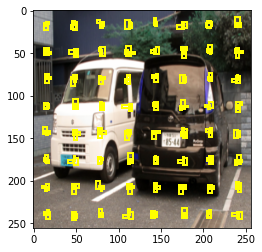

Original: 


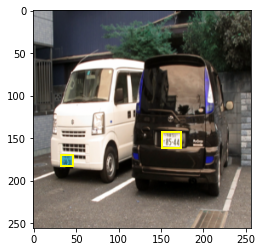

In [25]:
test = KaggleLicence(
    data_directory = 'DATASET/images/test',
    batch_size = 4
).__iter__()

for x, y in test:
    bboxes = cells_to_bboxes(y[0], anchors = config.ANCHORS[1], S = 8, is_preds = False)
    
    bbox = YOLO_model(x[2:3])
    bboxes_2 = cells_to_bboxes(bbox[0], anchors = config.ANCHORS[1], S = 8, is_preds = True)
    
    print('\n\nPrediction: ')
    plot_image(x[2], bboxes_2[0])
    
    print("Original: ")
    plot_image(x[2], bboxes[2])
    break

### FUNCTIONS TODO
* Save and Load checkpoints